# **CUSTOMER SEGMENTATION**
By- Nitya Mittal (2K19/MC/089) & Devika Jaiswal (2K19/MC/038)

# **1. Data Preparation**

In [ ]:
# Importing standard libraries

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn import preprocessing
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt

In [ ]:
df = pd.read_excel('Online Retail.xlsx')

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# give some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


While looking at the number of null values in the dataframe, it is interesting to note that  ∼ 25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So we delete them from the dataframe:

In [ ]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df.shape)

tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


By removing these entries we end up with a dataframe filled at 100% for all variables! Finally, we check for duplicate entries and delete them:

In [ ]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))

Duplicate entries: 5225
1% rows are duplicate.


In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **2. Data Preprocessing**

Checking the total number of products, transactions and customers

In [ ]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


Let's look at the countries from which orders were made show the result on a chloropleth map

In [ ]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of countries in dataset: {}'.format(len(countries)))

No. of countries in dataset: 37


In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

We see that the dataset is largely dominated by orders made from the UK

Checking country wise distribution of transactions

In [ ]:
temp = df.groupby(['Country'],as_index=False).agg({'InvoiceNo':'nunique'}).rename(columns = {'InvoiceNo':'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100,4)
temp.sort_values(by=['%Orders'],ascending=False,inplace=True)
temp.reset_index(drop=True,inplace=True)

Text(0, 0.5, '%Orders')

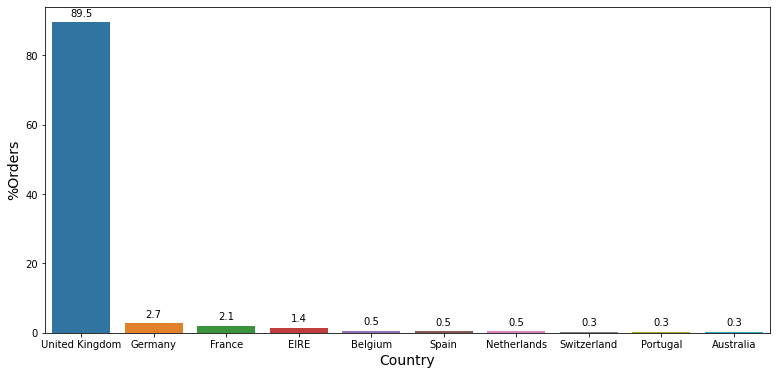

In [ ]:
plt.figure(figsize=(13,6))
splot=sns.barplot(x="Country",y="%Orders",data=temp[:10])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Country", size=14)
plt.ylabel("%Orders", size=14)

Now let's determine the number of products purchased in every transaction

In [ ]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


From this list, we can infer the following:
*   the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
*   the existence of users who only came once and only purchased one product 
*   the existence of frequent users that buy a large number of items at each order

Removing cancelled orders from the data

In [ ]:
invoices = df['InvoiceNo']

In [ ]:
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)

In [ ]:
x = x.astype(int)

In [ ]:
x.value_counts()

0    392732
1      8872
Name: InvoiceNo, dtype: int64

In [ ]:
df['order_canceled'] = x
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [ ]:
df['order_canceled'].value_counts()

0    392732
1      8872
Name: order_canceled, dtype: int64

In [ ]:
n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 8872/401604 (2.21%) 


In [ ]:
df = df.loc[df['order_canceled'] == 0,:]

In [ ]:
df.reset_index(drop=True,inplace=True)

Data is filtered to contain orders only from the United Kingdom since that is our target demographic 

In [ ]:
df_uk = df[df.Country == 'United Kingdom']

In [ ]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [ ]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 392716
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       349227 non-null  object        
 1   StockCode       349227 non-null  object        
 2   Description     349227 non-null  object        
 3   Quantity        349227 non-null  int64         
 4   InvoiceDate     349227 non-null  datetime64[ns]
 5   UnitPrice       349227 non-null  float64       
 6   CustomerID      349227 non-null  float64       
 7   Country         349227 non-null  object        
 8   order_canceled  349227 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 26.6+ MB


Thus, there are no nulls in any of the columns in the data with total 349227 rows in the data

Let us now check the number of products, transactions, and customers in our cleaned data:

In [ ]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3665,18536,4339


# **3. Cohort Analysis**

Now, we will create Time cohorts and look at customers who remain active during particular cohorts over a period of time that they transact over.

In [ ]:
cohort_data = df_uk[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']]

In [ ]:
# Checking for nulls in the data.
cohort_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
#converting to date format
all_dates = (pd.to_datetime(cohort_data['InvoiceDate'])).apply(lambda x:x.date())

Let us check the date range of our data.

In [ ]:
(all_dates.max() - all_dates.min()).days

373

In [ ]:
# Start and end dates:
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-01
End date: 2011-12-09


In [ ]:
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

cohort_data['InvoiceMonth'] = cohort_data['InvoiceDate'].apply(get_month)
grouping = cohort_data.groupby('CustomerID')['InvoiceMonth']
cohort_data['CohortMonth'] = grouping.transform('min')
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [ ]:
def get_date_int(df, column):    
    year = df[column].dt.year    
    month = df[column].dt.month    
    day = df[column].dt.day
    return year, month, day

Next, we need to find the difference between the InvoiceMonth and the CohortMonth column in terms of the number of months

In [ ]:
invoice_year, invoice_month, _ = get_date_int(cohort_data, 'InvoiceMonth') 
cohort_year, cohort_month, _ = get_date_int(cohort_data, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
cohort_data['CohortIndex'] = years_diff * 12 + months_diff
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0


we obtain the cohort analysis matrix by grouping the data by CohortMonth and CohortIndex

In [ ]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us now calculate the Retention Rate. It is defined as the percentage of active customers out of total customers

In [ ]:
cohort_sizes = cohort_counts.iloc[:,0]

# Divide all values in the cohort_counts table by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Review the retention table
retention.round(3) * 100
retention

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.354601,0.322699,0.373006,0.359509,0.396319,0.357055,0.341104,0.354601,0.398773,0.366871,0.496933,0.267485
2011-01-01,1.0,0.212291,0.259777,0.234637,0.332402,0.276536,0.251397,0.243017,0.301676,0.326816,0.354749,0.120112,NaN
2011-02-01,1.0,0.188235,0.194118,0.285294,0.288235,0.252941,0.255882,0.282353,0.264706,0.305882,0.073529,NaN,NaN
2011-03-01,1.0,0.152745,0.260143,0.198091,0.224344,0.164678,0.264916,0.229117,0.284010,0.090692,NaN,NaN,NaN
2011-04-01,1.0,0.209386,0.202166,0.216606,0.202166,0.220217,0.220217,0.263538,0.072202,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.187500,0.171875,0.171875,0.207031,0.226562,0.265625,0.089844,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.177570,0.144860,0.238318,0.238318,0.322430,0.098131,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.177515,0.195266,0.230769,0.278107,0.106509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.226950,0.226950,0.241135,0.120567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us now visualize the retention rates by a heatmap.

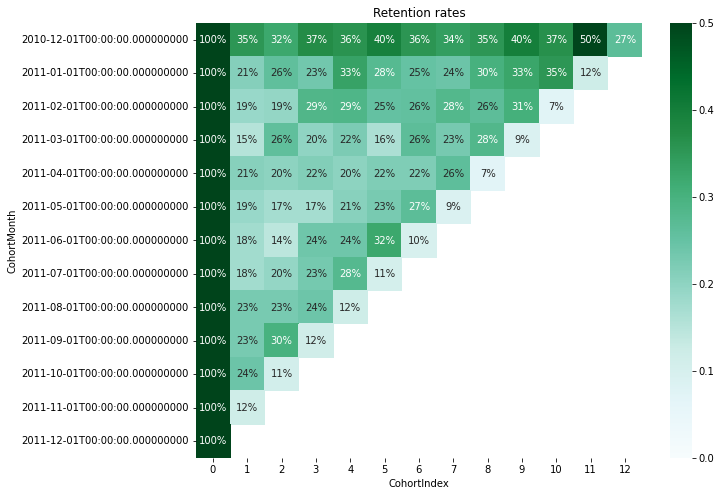

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

# **4. RFM Segmentatiom**

RFM stands for Recency, Frequency, and Monetary. RFM analysis is a commonly used technique to generate and assign a score to each customer based on R, F and M

In [ ]:
#get the monetary value of each transaction by multiplying the UnitValue column with the Quantity column.
cohort_data = df_uk[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']]
cohort_data['TotalSum'] = cohort_data['Quantity']*cohort_data['UnitPrice']
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Let us check the distribution of the TotalSum column to understand customer spending.

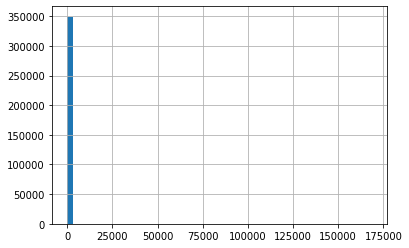

In [ ]:
cohort_data.TotalSum.hist(bins=50)

In [ ]:
cohort_data[['TotalSum']].describe()

,TotalSum
count,349227.000000
mean,20.860428
std,328.406035
min,0.000000
25%,4.200000
50%,10.200000
75%,17.850000
max,168469.600000


In [ ]:
cohort_data[cohort_data['TotalSum']> 17.850000].sort_values('TotalSum',ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
392266,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60
36527,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
153601,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
116879,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75
246062,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72
...,...,...,...,...,...,...,...,...,...
65572,545081,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 10:35:00,1.49,16057.0,United Kingdom,17.88
89499,547921,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-03-28 13:28:00,1.49,14766.0,United Kingdom,17.88
65822,545150,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 12:27:00,1.49,14227.0,United Kingdom,17.88
31685,540691,21673,WHITE SPOT BLUE CERAMIC DRAWER KNOB,12,2011-01-11 08:50:00,1.49,17450.0,United Kingdom,17.88


Next, we define the ‘snapshot date’ and we confine the data to a period of one year
and finally calculated the RFM metrics for each customer


Let us check the max date and take data till a year behind the max date.

In [ ]:
from dateutil.relativedelta import relativedelta
start_date = all_dates.max()-relativedelta(months=12,days=-1)
print('Start date: {}'.format(start_date))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-10
End date: 2011-12-09


In [ ]:
data_rfm = cohort_data[cohort_data['InvoiceDate'] >= pd.to_datetime(start_date)]
data_rfm.reset_index(drop=True,inplace=True)
data_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10 09:33:00,1.25,15805.0,United Kingdom,15.0
1,538172,79321,CHILLI LIGHTS,8,2010-12-10 09:33:00,4.95,15805.0,United Kingdom,39.6
2,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10 09:33:00,2.55,15805.0,United Kingdom,30.6
3,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10 09:33:00,2.95,15805.0,United Kingdom,35.4
4,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10 09:33:00,0.55,15805.0,United Kingdom,13.2


In [ ]:
snapshot_date = max(data_rfm.InvoiceDate) + dt.timedelta(days=1)
print('Snapshot date: {}'.format(snapshot_date.date()))

Snapshot date: 2011-12-10


In [ ]:
# Aggregate data on a customer level
data = data_rfm.groupby(['CustomerID'],as_index=False).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                             'InvoiceNo': 'count',
                                             'TotalSum': 'sum'}).rename(columns = {'InvoiceDate': 'Recency',
                                                                                   'InvoiceNo': 'Frequency',
                                                                                   'TotalSum': 'MonetaryValue'})

# Check the first rows
data.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326,1,77183.60
1,12747.0,2,96,3837.45
2,12748.0,1,4055,31081.74
3,12749.0,4,199,4090.88
4,12820.0,3,59,942.34


As the next step, we create quartiles on this data as described above and collate these scores into an RFM_Segment column. The RFM_Score is calculated by summing up the RFM quartile metrics.

In [ ]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(data['Recency'], 4, labels = r_labels)
data = data.assign(R = r_quartiles.values)

f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(data['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(data['MonetaryValue'], 4, labels = m_labels)
data = data.assign(F = f_quartiles.values)
data = data.assign(M = m_quartiles.values)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M
0,12346.0,326,1,77183.60,1,1,4
1,12747.0,2,96,3837.45,4,3,4
2,12748.0,1,4055,31081.74,4,4,4
3,12749.0,4,199,4090.88,4,4,4
4,12820.0,3,59,942.34,4,3,3


In [ ]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

data['RFM_Segment'] = data.apply(join_rfm, axis=1)
data['RFM_Score'] = data[['R','F','M']].sum(axis=1)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
1,12747.0,2,96,3837.45,4,3,4,4.03.04.0,11
2,12748.0,1,4055,31081.74,4,4,4,4.04.04.0,12
3,12749.0,4,199,4090.88,4,4,4,4.04.04.0,12
4,12820.0,3,59,942.34,4,3,3,4.03.03.0,10


Let us now analyse RFM Score distribution and their groups.

In [ ]:
data.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           242.6       7.9         149.8   324
4           171.0      13.7         224.3   353
5           147.6      20.0         351.1   456
6            87.4      27.0         807.3   432
7            80.8      38.9         717.1   399
8            56.3      52.0         930.3   397
9            43.8      73.5        1757.9   373
10           32.0     110.4        1869.3   389
11           20.6     183.7        3405.9   334
12            6.9     351.9        8027.9   398

In [ ]:
def create_segment(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Middle'
    else:
        return 'Low'
    
data['General_Segment'] = data.apply(create_segment, axis=1)
data.groupby('General_Segment').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Low               205.3      10.9         188.7   677
Middle             94.8      33.8         691.4  1684
Top                25.7     181.9        3825.7  1494

# **5. Preprocessing data for Clustering**

Let us check the first assumption by building histograms of Recency, Frequency, and MonetaryValue variables using the seaborn library:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



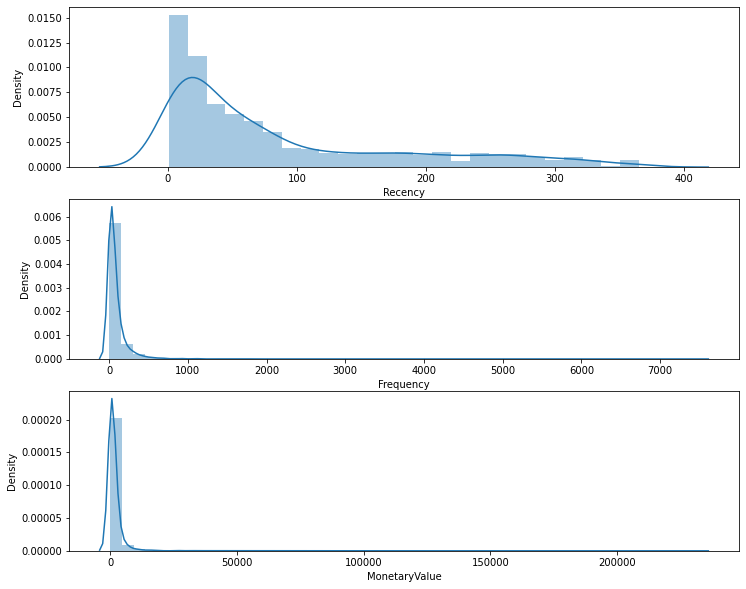

In [ ]:
# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))

# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])

# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data['MonetaryValue'])

In [ ]:
# Checking for constant mean and variance.
data[['Recency','Frequency','MonetaryValue']].describe()

,Recency,Frequency,MonetaryValue
count,3855.000000,3855.000000,3855.000000
mean,87.428016,87.205966,1817.792603
std,93.428162,209.411865,7190.041841
min,1.000000,1.000000,0.000000
25%,17.000000,16.000000,291.680000
50%,50.000000,40.000000,638.060000
75%,134.000000,96.000000,1545.515000
max,365.000000,7491.000000,231822.690000


Removing the customer with 0 MonetaryValue from the data:

In [ ]:
data[data['MonetaryValue'] == 0]

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
310,13256.0,14,1,0.0,4,1,1,4.01.01.0,6,Middle


In [ ]:
data = data[data['MonetaryValue'] > 0]
data.reset_index(drop=True,inplace=True)

In [ ]:
raw_data = data[['Recency','Frequency','MonetaryValue']]


Let us now apply log transformation to the data and normalize it.

In [ ]:
# Unskew the data
data_log = np.log(raw_data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)

In [ ]:
data_norm.head()

,Recency,Frequency,MonetaryValue
0,5.786897,0.000000,11.253942
1,0.693147,4.564348,8.252563
2,0.000000,8.307706,10.344376
3,1.386294,5.293305,8.316515
4,1.098612,4.077537,6.848366



Checking for skewness in the data now:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



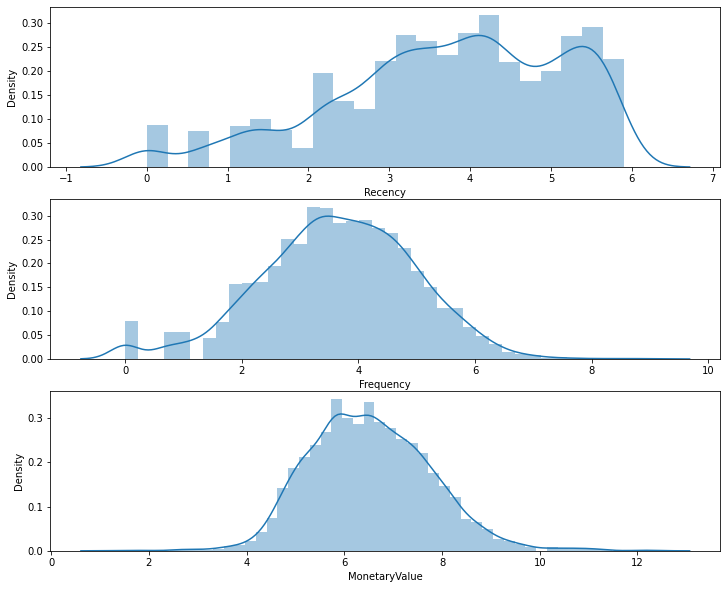

In [ ]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['MonetaryValue'])

# Show the plot
plt.show()


As we can see from the above plots, skewness has been removed from the data.

# **6. Clustering with K-means algorithm**

we will build multiple clusters upon our RFM data (data_norm) and will try to find out the optimal number of clusters in our data using the elbow method.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

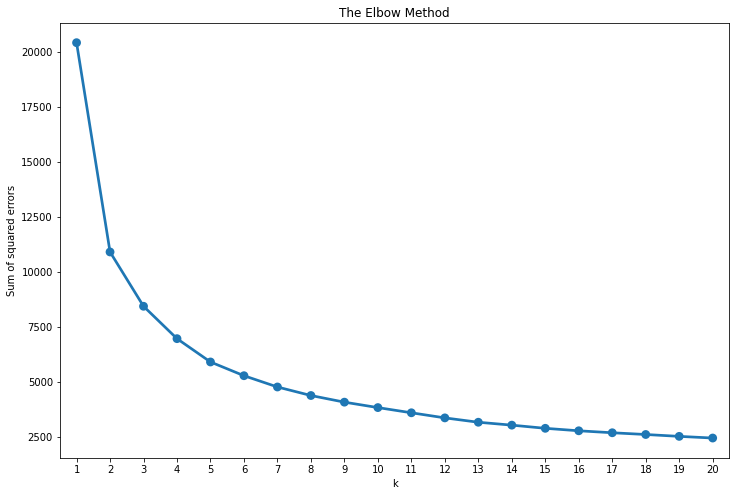

In [ ]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

From the above plot, we can see that the optimal number of cluster is 3 or 4.

Let us take k = 3 first.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [ ]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k3

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          66.0      67.0        1183.0  1637
1         162.0      15.0         285.0  1360
2          11.0     241.0        5464.0   857


Let us now take k = 4.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [ ]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k4

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          21.0      34.0         525.0   770
1         178.0      15.0         293.0  1216
2          10.0     269.0        6197.0   721
3          85.0      85.0        1551.0  1147

# **7. Interpreting the outcome**


Let us view the results side by side.

In [ ]:
display(summary_k3)
display(summary_k4)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          66.0      67.0        1183.0  1637
1         162.0      15.0         285.0  1360
2          11.0     241.0        5464.0   857

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          21.0      34.0         525.0   770
1         178.0      15.0         293.0  1216
2          10.0     269.0        6197.0   721
3          85.0      85.0        1551.0  1147

Before building snakeplots, let us assign back customerID values to the row indices.

In [ ]:
data_norm_k4.index = data['CustomerID'].astype(int)

In [ ]:
data_norm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,5.786897,0.000000,11.253942,3
12747,0.693147,4.564348,8.252563,2
12748,0.000000,8.307706,10.344376,2
12749,1.386294,5.293305,8.316515,2
12820,1.098612,4.077537,6.848366,2


In [ ]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k4.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                    var_name='Attribute',
                    value_name='Value')

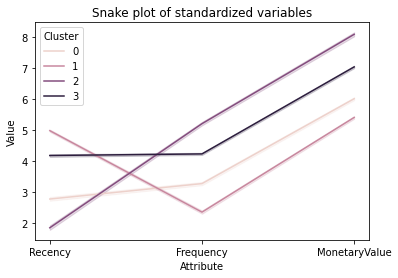

In [ ]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)

In [ ]:
data_k4.index = data['CustomerID'].astype(int)
data_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,326,1,77183.60,3
12747,2,96,3837.45,2
12748,1,4055,31081.74,2
12749,4,199,4090.88,2
12820,3,59,942.34,2


In [ ]:
raw_data.index = data['CustomerID'].astype(int)
raw_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12747,2,96,3837.45
12748,1,4055,31081.74
12749,4,199,4090.88
12820,3,59,942.34


 Calculate average values of each cluster

In [ ]:
cluster_avg = data_k4.groupby(['Cluster']).mean()
population_avg = raw_data.head().mean()

In [ ]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,21.358442,34.475325,525.498494
1,178.092928,14.846217,293.134425
2,9.758669,268.549237,6196.815354
3,84.549259,85.401046,1550.655024


Calculate average values of population

In [ ]:
population_avg

Recency             67.200
Frequency          882.000
MonetaryValue    23427.202
dtype: float64

Calculate importance score by dividing them and subtracting 1 

In [ ]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.68,-0.96,-0.98
1,1.65,-0.98,-0.99
2,-0.85,-0.70,-0.74
3,0.26,-0.90,-0.93


 Understand the relative importance of segments in the data by plotting heatmap

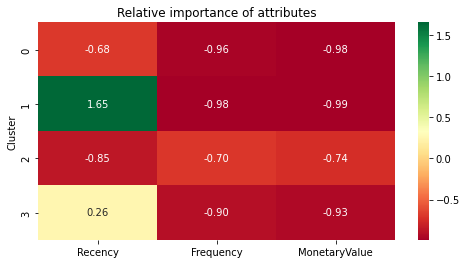

In [ ]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()